In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
import seaborn as sns
import itertools
from tqdm import tqdm
import joblib

In [2]:
d0 = np.array([1.])

In [3]:
use_πD = False

In [28]:
N = 200

# %Missing counterfactual annotations, constant mean split weights, no impute

In [5]:
def single_run_pcannot(pc_annots, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    ## probability of getting a counterfactual annotation
    Pc_local = pc_annots
    
    ww = ww_constant
    
    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc_local[xi,ai], Pc_local[xi,ai]]) for xi,ai in zip(x,a)])
        
        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]
        
        # print(x,a,r,c,rc,w,wc)
        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            π_b_ = np.array([
                [(1-Pc_local[0,0])*π_b[0,0] + Pc_local[0,0]*π_b[0,0]*ww[0,0,0] + Pc_local[0,1]*π_b[0,1]*ww[0,1,0], 
                 (1-Pc_local[0,1])*π_b[0,1] + Pc_local[0,0]*π_b[0,0]*ww[0,0,1] + Pc_local[0,1]*π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)

        # print(π_b_)
        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

In [6]:
ww_constant = np.array([[
    [0.5, 0.5],
    [0.5, 0.5],
]])

In [7]:
pc_annot_list = list(np.arange(0,1+1e-10,0.1).round(2))
pc_annot_list

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [8]:
R, sigma = np.array([[1., 2.],]), np.array([[1., 1.],])

In [9]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [29]:
df_out_sweepPcannot_1 = []
for pc0, pc1 in tqdm(list(itertools.product(pc_annot_list, pc_annot_list))):
    df_out = single_run_pcannot(np.array([[pc0, pc1]]), runs=50)
    df_out_sweepPcannot_1.append(df_out)

100%|██████████| 121/121 [09:59<00:00,  4.95s/it]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


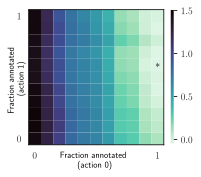

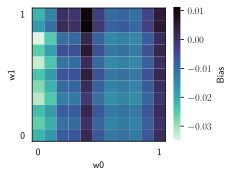

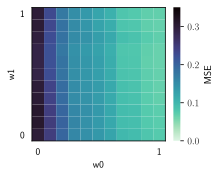

In [53]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'pc0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'pc1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T*np.sqrt(N)), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            vmin=-0.05, vmax=1.5,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
# ax.collections[0].colorbar.set_ticks([0, 0.25])
# ax.collections[0].colorbar.set_ticklabels(['$0$', r'$\frac{1}{4}$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('Fraction annotated\n(action 0)', labelpad=-9, fontsize=9)
plt.ylabel('Fraction annotated\n(action 1)', labelpad=-9, fontsize=9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19_Pcannot.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, 
            # vmin=0, vmax=2, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, 
            vmin=0, vmax=0.35, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [35]:
df_plot

w1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
w0,,,,,,,,,,,
0.0,0.301216,0.311262,0.312384,0.305866,0.302840,0.290237,0.290493,0.290794,0.297690,0.304301,0.303111
0.1,0.247512,0.250026,0.246246,0.241397,0.240124,0.227268,0.223054,0.222931,0.227780,0.234947,0.231729
0.2,0.198264,0.203045,0.199342,0.191490,0.190938,0.182460,0.183227,0.178180,0.184667,0.185445,0.177459
0.3,0.159840,0.161646,0.159425,0.153376,0.153569,0.149086,0.149533,0.147111,0.154603,0.155065,0.151364
0.4,0.148041,0.146528,0.148626,0.143878,0.143297,0.140153,0.140371,0.136429,0.144888,0.141565,0.137793
0.5,0.138247,0.136041,0.137094,0.133210,0.133247,0.130171,0.130030,0.126217,0.131596,0.125140,0.122939
0.6,0.123096,0.120014,0.120050,0.117065,0.117856,0.114041,0.112476,0.110436,0.117793,0.112539,0.109014
0.7,0.099219,0.095393,0.095456,0.091722,0.090424,0.086460,0.084088,0.083264,0.091986,0.084697,0.082471
0.8,0.094744,0.092672,0.091872,0.088009,0.086528,0.084289,0.082206,0.081380,0.086909,0.080975,0.078607


In [36]:
df_plot.mean()

w1
0.0    0.151912
0.1    0.151775
0.2    0.150971
0.3    0.146387
0.4    0.145485
0.5    0.140346
0.6    0.139150
0.7    0.137679
0.8    0.144081
0.9    0.142072
1.0    0.139425
dtype: float64

In [17]:
single_run_pcannot(np.array([[0,0]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.780833,-0.119167,0.223268,0.253080
5,C-WIS,1.860249,-0.039751,0.214985,0.218629


In [18]:
single_run_pcannot(np.array([[1,1]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.888505,-0.011495,0.069931,0.070870
5,C-WIS,1.888505,-0.011495,0.069931,0.070870


In [19]:
single_run_pcannot(np.array([[0.5, 0.5]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.874901,-0.025099,0.145973,0.148116
5,C-WIS,1.883400,-0.016600,0.112195,0.113416


# %Missing counterfactual annotations, constant mean split weights, impute annotations

In [88]:
def single_run_pcannot_impute(pc_annots, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    ## probability of getting a counterfactual annotation
    Pc_local = pc_annots
    
    ww = ww_constant
    
    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc_local[xi,ai], Pc_local[xi,ai]]) for xi,ai in zip(x,a)])
        # print(c)

        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # impute missing counterfactuals
        rc_impute = np.full_like(rc, np.nan)
        c_impute = np.full_like(c, 0)
        for i, (ci,xi,ai) in enumerate(zip(c,x,a)):
            if ci == 1:
                pass
            else:
                rc_src = rc[(c==1) & (x==xi) & (a==ai)]
                if len(rc_src) > 0:
                    rc_impute[i] = np.mean(rc_src)
                    c_impute[i] = 1
        
        rc[c==0] = rc_impute[c==0]
        c[c==0] = c_impute[c==0]
        
        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]
        
        # print('a', a, 'r', r, 'c', c, 'rc', rc, 'w', w, 'wc', wc)
        # print(np.sum(w), np.sum(wc))
        
        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            Pc_round = (Pc_local > 0).astype(int)
            π_b_ = np.array([
                [(1-Pc_round[0,0])*π_b[0,0] + Pc_round[0,0]*π_b[0,0]*ww[0,0,0] + Pc_round[0,1]*π_b[0,1]*ww[0,1,0], 
                 (1-Pc_round[0,1])*π_b[0,1] + Pc_round[0,0]*π_b[0,0]*ww[0,0,1] + Pc_round[0,1]*π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)
        # print(Pc_local)
        # print(Pc_round)
        # print(π_b_)
        
        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

In [92]:
single_run_pcannot_impute(np.array([[0., 0.1]]), runs=5)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.906469,0.006469,0.117766,0.117944
1,$\hat{v}(\pi_b)$,1.208469,-0.691531,0.132154,0.704045
2,OIS,1.831194,-0.068806,0.215124,0.225860
3,WIS,1.948024,0.048024,0.206336,0.211851
4,C-OIS,2.522573,0.622573,0.926232,1.116021
5,C-WIS,1.976511,0.076511,0.233438,0.245657


In [94]:
single_run_pcannot(np.array([[0., 0.1]]), runs=5)

[[0.81 0.19]]
[[0.81 0.19]]
[[0.81 0.19]]
[[0.81 0.19]]
[[0.81 0.19]]


,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.874441,-0.025559,0.017853,0.031177
1,$\hat{v}(\pi_b)$,1.184441,-0.715559,0.035242,0.716426
2,OIS,1.881578,-0.018422,0.177402,0.178356
3,WIS,1.888907,-0.011093,0.076511,0.077311
4,C-OIS,1.864218,-0.035782,0.185121,0.188548
5,C-WIS,1.886975,-0.013025,0.077064,0.078157


In [28]:
ww_constant = np.array([[
    [0.5, 0.5],
    [0.5, 0.5],
]])

In [29]:
pc_annot_list = list(np.arange(0,1+1e-10,0.1).round(2))
pc_annot_list

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [30]:
R, sigma = np.array([[1., 2.],]), np.array([[1., 1.],])

In [31]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [104]:
df_out_sweepPcannot_2 = []
for pc0, pc1 in tqdm(list(itertools.product(pc_annot_list, pc_annot_list))):
    df_out = single_run_pcannot_impute(np.array([[pc0, pc1]]), runs=50)
    df_out_sweepPcannot_2.append(df_out)

100%|██████████| 121/121 [10:58<00:00,  5.44s/it]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


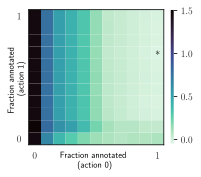

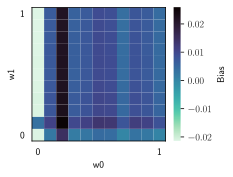

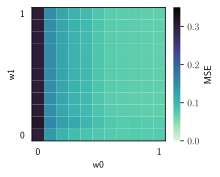

In [114]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T*np.sqrt(N)), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            vmin=-0.05, vmax=1.5,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
# ax.collections[0].colorbar.set_ticks([0, 0.25])
# ax.collections[0].colorbar.set_ticklabels(['$0$', r'$\frac{1}{4}$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('Fraction annotated\n(action 0)', labelpad=-9, fontsize=9)
plt.ylabel('Fraction annotated\n(action 1)', labelpad=-9, fontsize=9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19_Pcannot_impute.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, 
            # vmin=0, vmax=2, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, 
            vmin=0, vmax=0.35, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [107]:
df_plot

w1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
w0,,,,,,,,,,,
0.0,0.301216,0.314693,0.304306,0.303777,0.303371,0.303286,0.303046,0.303220,0.303056,0.303098,0.303111
0.1,0.136664,0.158921,0.153528,0.153111,0.153153,0.153700,0.153508,0.153547,0.153855,0.153855,0.153808
0.2,0.105721,0.131082,0.121686,0.121514,0.121478,0.121978,0.121712,0.121616,0.121897,0.121875,0.121903
0.3,0.094148,0.119736,0.109256,0.109226,0.108936,0.109090,0.108925,0.108730,0.108983,0.109084,0.109028
0.4,0.086074,0.103618,0.098215,0.097816,0.097224,0.097267,0.097120,0.096792,0.097016,0.097134,0.097033
0.5,0.080511,0.089001,0.083648,0.083354,0.083049,0.083223,0.082860,0.082558,0.082973,0.083060,0.083053
0.6,0.077688,0.080173,0.075391,0.074965,0.074944,0.075016,0.074535,0.074234,0.074627,0.074700,0.074654
0.7,0.076064,0.076365,0.073144,0.072726,0.072838,0.072953,0.072494,0.072093,0.072497,0.072602,0.072725
0.8,0.077088,0.077133,0.071539,0.071050,0.071233,0.071391,0.071049,0.070711,0.071131,0.071268,0.071324


In [108]:
df_plot.mean()

w1
0.0    0.108108
0.1    0.118117
0.2    0.111837
0.3    0.111453
0.4    0.111343
0.5    0.111536
0.6    0.111237
0.7    0.111025
0.8    0.111326
0.9    0.111397
1.0    0.111402
dtype: float64

In [46]:
single_run_pcannot_impute(np.array([[0,0]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.780833,-0.119167,0.223268,0.253080
5,C-WIS,1.860249,-0.039751,0.214985,0.218629


In [49]:
single_run_pcannot_impute(np.array([[1,1]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.888505,-0.011495,0.069931,0.070870
5,C-WIS,1.888505,-0.011495,0.069931,0.070870
